In [2]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

/Users/benmagevney/miniconda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/benmagevney/miniconda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [3]:
data = pd.read_csv('../data/regional_univariate_data.csv', index_col=0)

In [4]:
data.head()

,region,new_confirmed
date,,
2020-01-19,Pacific,1.0
2020-01-20,Pacific,0.0
2020-01-21,Pacific,1.0
2020-01-22,East North Central,0.0
2020-01-22,East South Central,0.0


Here we can see that every group max date is 2022-09-15 except for South Atlantic which is 2022-12-30
but from 2022-09-16 to 2022-12-29 _newconfirmed_ is NAN

this is caused by the asfreq('d') call which ensure out datetime index step is 1 day so it imputes the missing dates in our range and fills them with NaN
to ensure each group has the same date interval we will limit the dataset to be from 2020-01-22 to 2022-09-15

In [44]:
for group, df in data.groupby('region'):
    print(group)
    series = df['new_confirmed']
    series.index = pd.to_datetime(series.index)
    series = series.asfreq('d')
    print(series.first_valid_index(), series.last_valid_index())
    print(series[series.isna()].size)

East North Central
2020-01-22 00:00:00 2022-09-15 00:00:00
0
East South Central
2020-01-22 00:00:00 2022-09-15 00:00:00
0
Mid-Atlantic
2020-01-22 00:00:00 2022-09-15 00:00:00
0
Mountain
2020-01-22 00:00:00 2022-09-15 00:00:00
0
New England
2020-01-22 00:00:00 2022-09-15 00:00:00
0
Pacific
2020-01-19 00:00:00 2022-09-15 00:00:00
0
South Atlantic
2020-01-22 00:00:00 2022-12-30 00:00:00
105
West North Central
2020-01-22 00:00:00 2022-09-15 00:00:00
0
West South Central
2020-01-22 00:00:00 2022-09-15 00:00:00
0


In [45]:
# limit the dataset to be from 2020-01-22 to 2022-09-15
data = data.loc['2020-01-22':'2022-09-15']

## Yearly Seasonality 

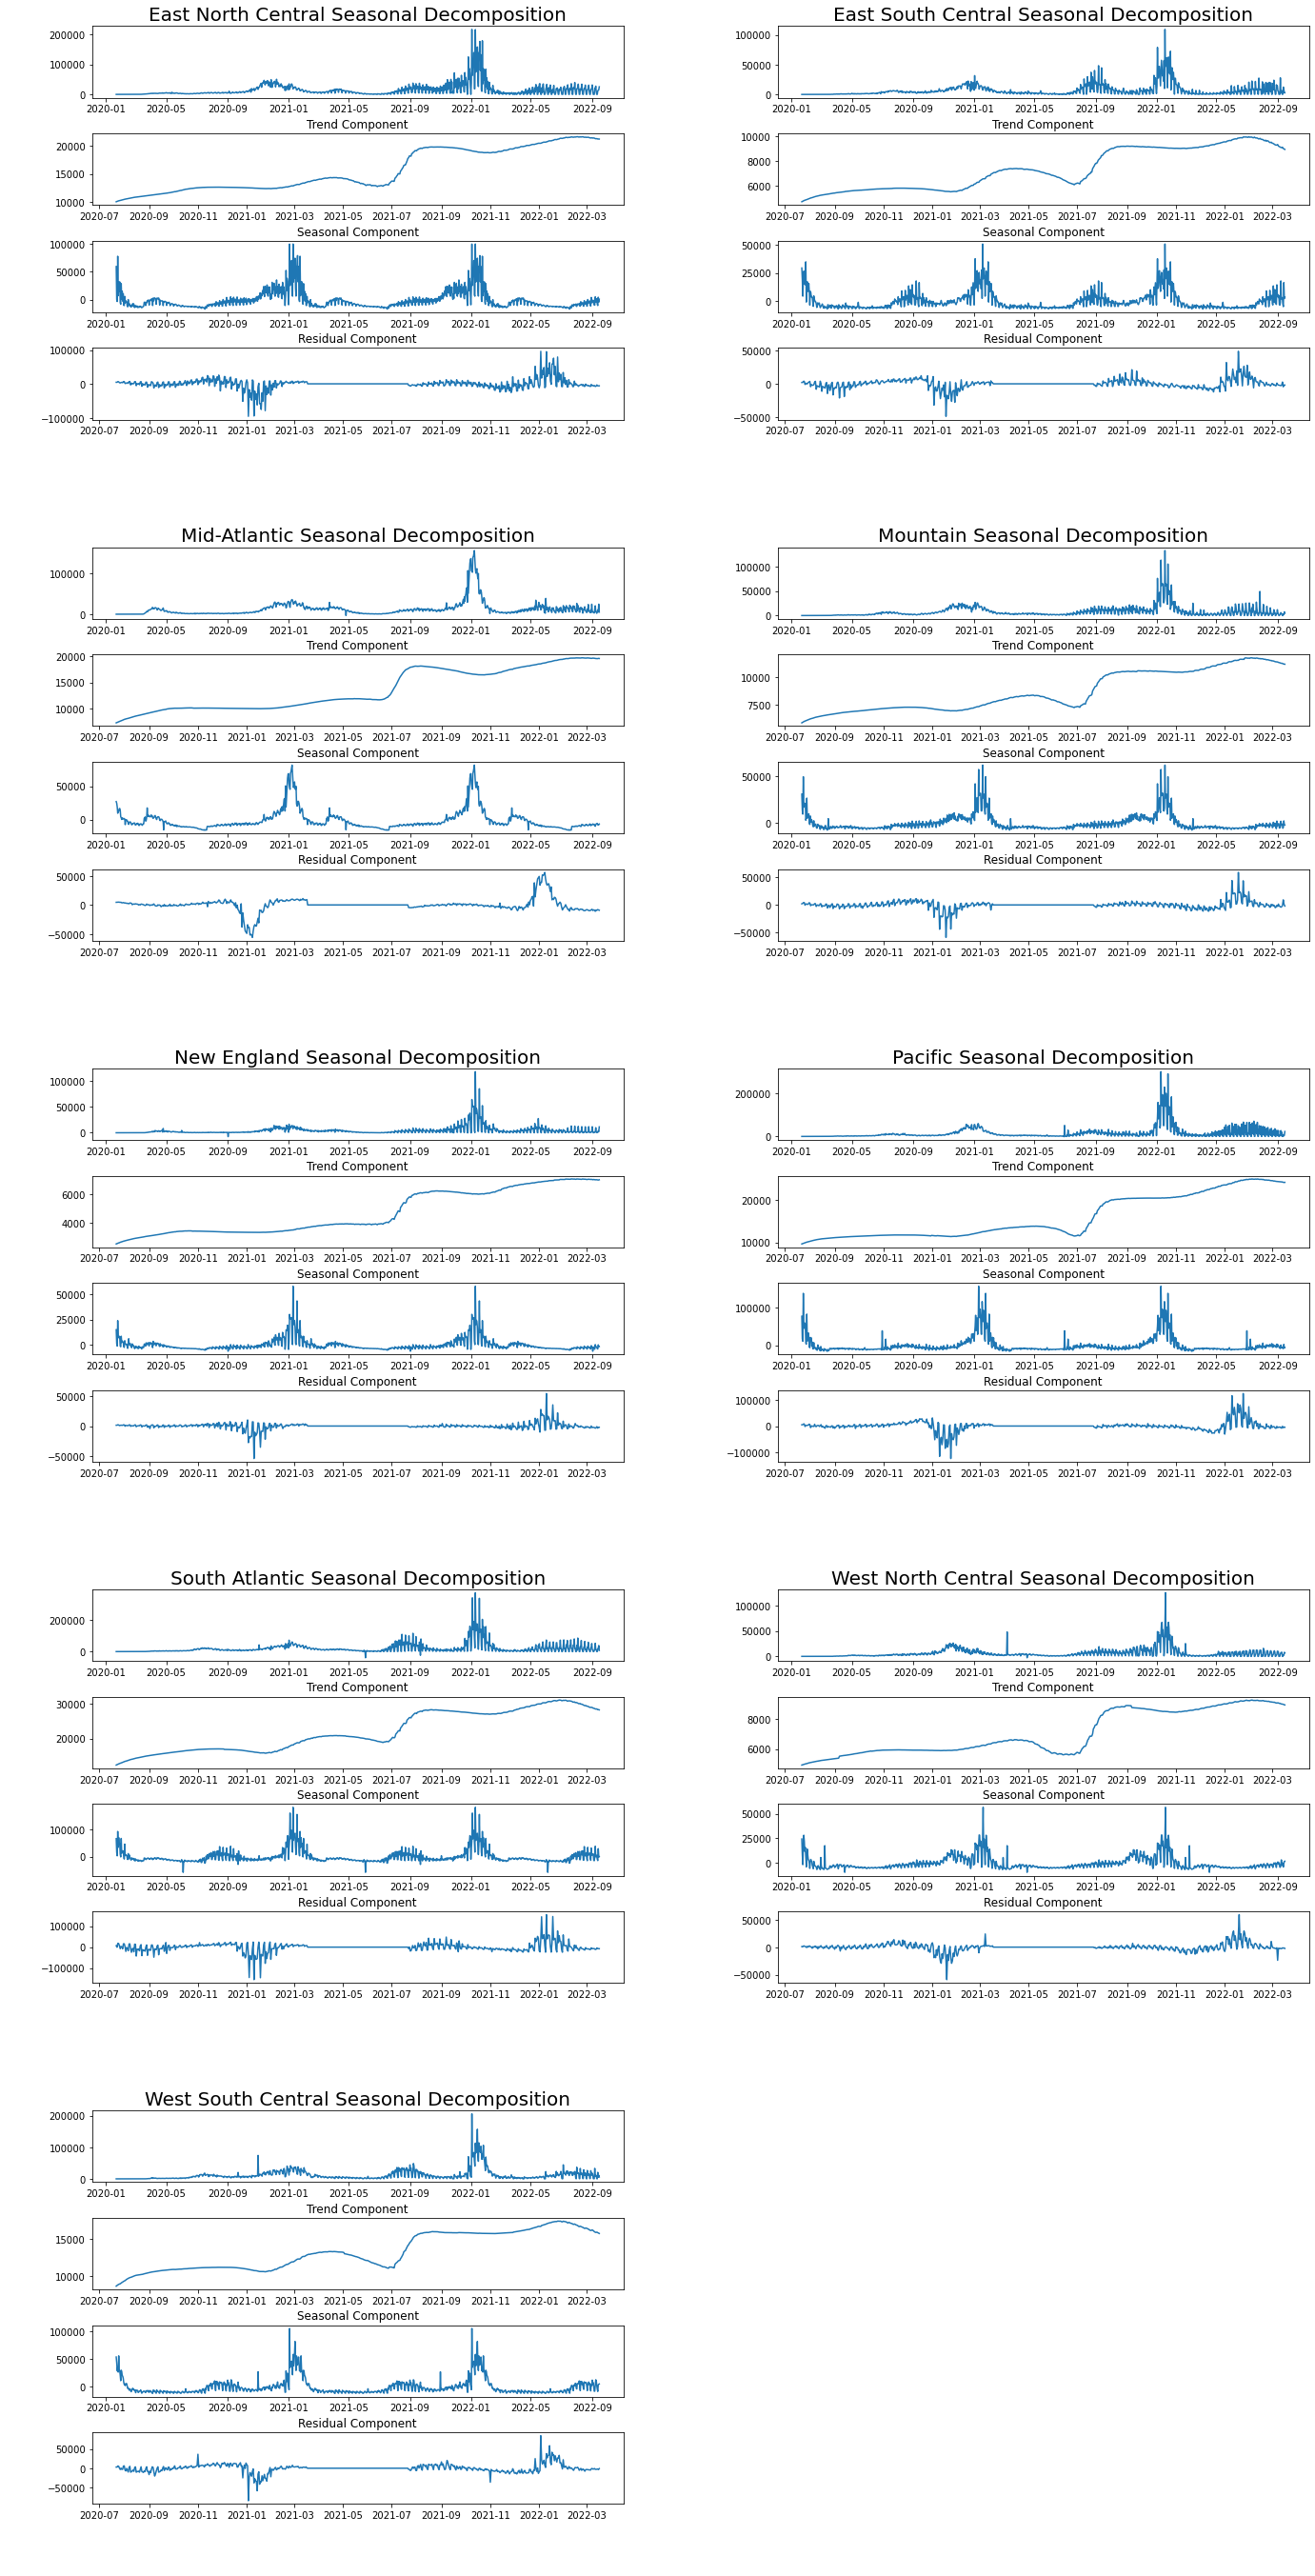

In [105]:
fig = plt.figure(figsize=(20, 38))
# fig.suptitle('Seasonal Decomposition of New Confirmed Cases', fontsize=20)
subfigs = fig.subfigures(5, 2)

i  = 0
for group, df in data.groupby('region'):
    subfig = subfigs.flat[i]
    i += 1
    # print(group)
    series = df['new_confirmed']
    series.index = pd.to_datetime(series.index)
    series = series.asfreq('d')

    # play with the period to check seasonality period=365 means yearly
    result = sm.tsa.seasonal_decompose(series, model='additive', period=int(365))

    # subfig
    subfig.figsize=(12, 8)
    # subfig.suptitle(f'{group} Seasonal Decomposition')
    subsubplots = subfig.subplots(4, 1,)

    # original data
    subsubplots[0].plot(series)
    subsubplots[0].set_title(f'{group} Seasonal Decomposition', fontsize=20)
    # seasonal decomposition
    subsubplots[1].plot(result.trend)
    subsubplots[1].set_title('Trend Component')
    subsubplots[2].plot(result.seasonal)
    subsubplots[2].set_title('Seasonal Component')
    subsubplots[3].plot(result.resid)
    subsubplots[3].set_title('Residual Component')

    subfig.subplots_adjust(hspace=0.5)

# 
# fig.subplots_adjust(top=0.9)


### Findings
In the original dataset we have a small spike in january 2021 and a major spike in jan 2022

**trend**
the trend captures this spike well, but the trend period in late 2022 is a bit higher than it should (this is casued by the yearly period we selected in the seasonal decomposition)
- the spikes indicate new wave in infections

**seasonality**
we have a yearly period selected so we can see major spikes at the end and beginning of a new year
one hypothesis is that holiday travel could influence the major spike in new cases across the country 

**residuals**
not quite sure what we use residuals for 
but having little to no spikes is good because it means we dont vary from the trend and seasoanlty much, unfortunately we have some spikes

**takeaways**
we can use findings using different periods in seasonal decompisition to help identify periods for a potential SARIMA model (seasonal ARIMA)

